In [8]:
import deepxde as dde
import numpy as np
from deepxde.backend import torch
import matplotlib.pyplot as plt

In [2]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

    return (
        dy_t
        - dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

In [3]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

In [4]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [5]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

Compiling model...
'compile' took 2.636631 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.65e+01, 1.39e-01, 8.49e-01]    [1.77e+01, 1.39e-01, 8.49e-01]    [1.45e+00]    
1000      [3.01e-03, 1.80e-03, 3.49e-04]    [6.78e-03, 1.80e-03, 3.49e-04]    [5.60e-02]    
2000      [6.11e-04, 2.50e-04, 6.76e-05]    [1.50e-03, 2.50e-04, 6.76e-05]    [2.42e-02]    
3000      [2.00e-03, 2.36e-04, 7.16e-05]    [1.30e-03, 2.36e-04, 7.16e-05]    [2.10e-02]    
4000      [2.33e-04, 2.71e-05, 8.76e-06]    [6.49e-04, 2.71e-05, 8.76e-06]    [6.37e-03]    
5000      [1.09e-04, 1.63e-05, 3.84e-06]    [4.13e-04, 1.63e-05, 3.84e-06]    [5.24e-03]    
6000      [8.97e-05, 1.57e-05, 3.44e-06]    [3.15e-04, 1.57e-05, 3.44e-06]    [4.65e-03]    
7000      [8.70e-05, 1.71e-05, 5.08e-06]    [2.35e-04, 1.71e-05, 5.08e-06]    [5.03e-03]    
8000      [4.28e-05, 1.31e-05, 2.65e-06]    [1.89e-04, 1.31e-05, 2.65e-06]    [4.14e-03]    
9000 

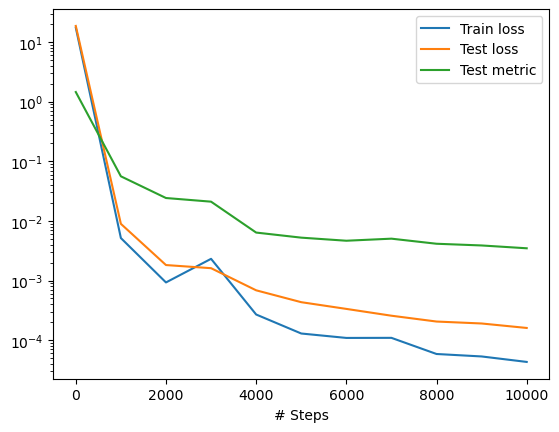

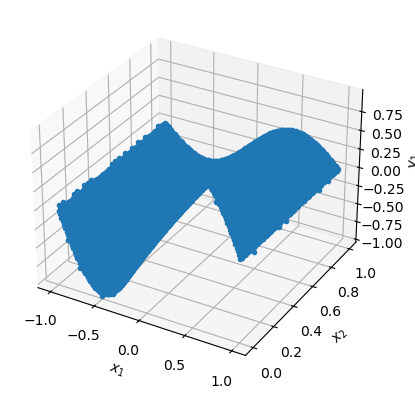

In [6]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000, model_save_path="diff")

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

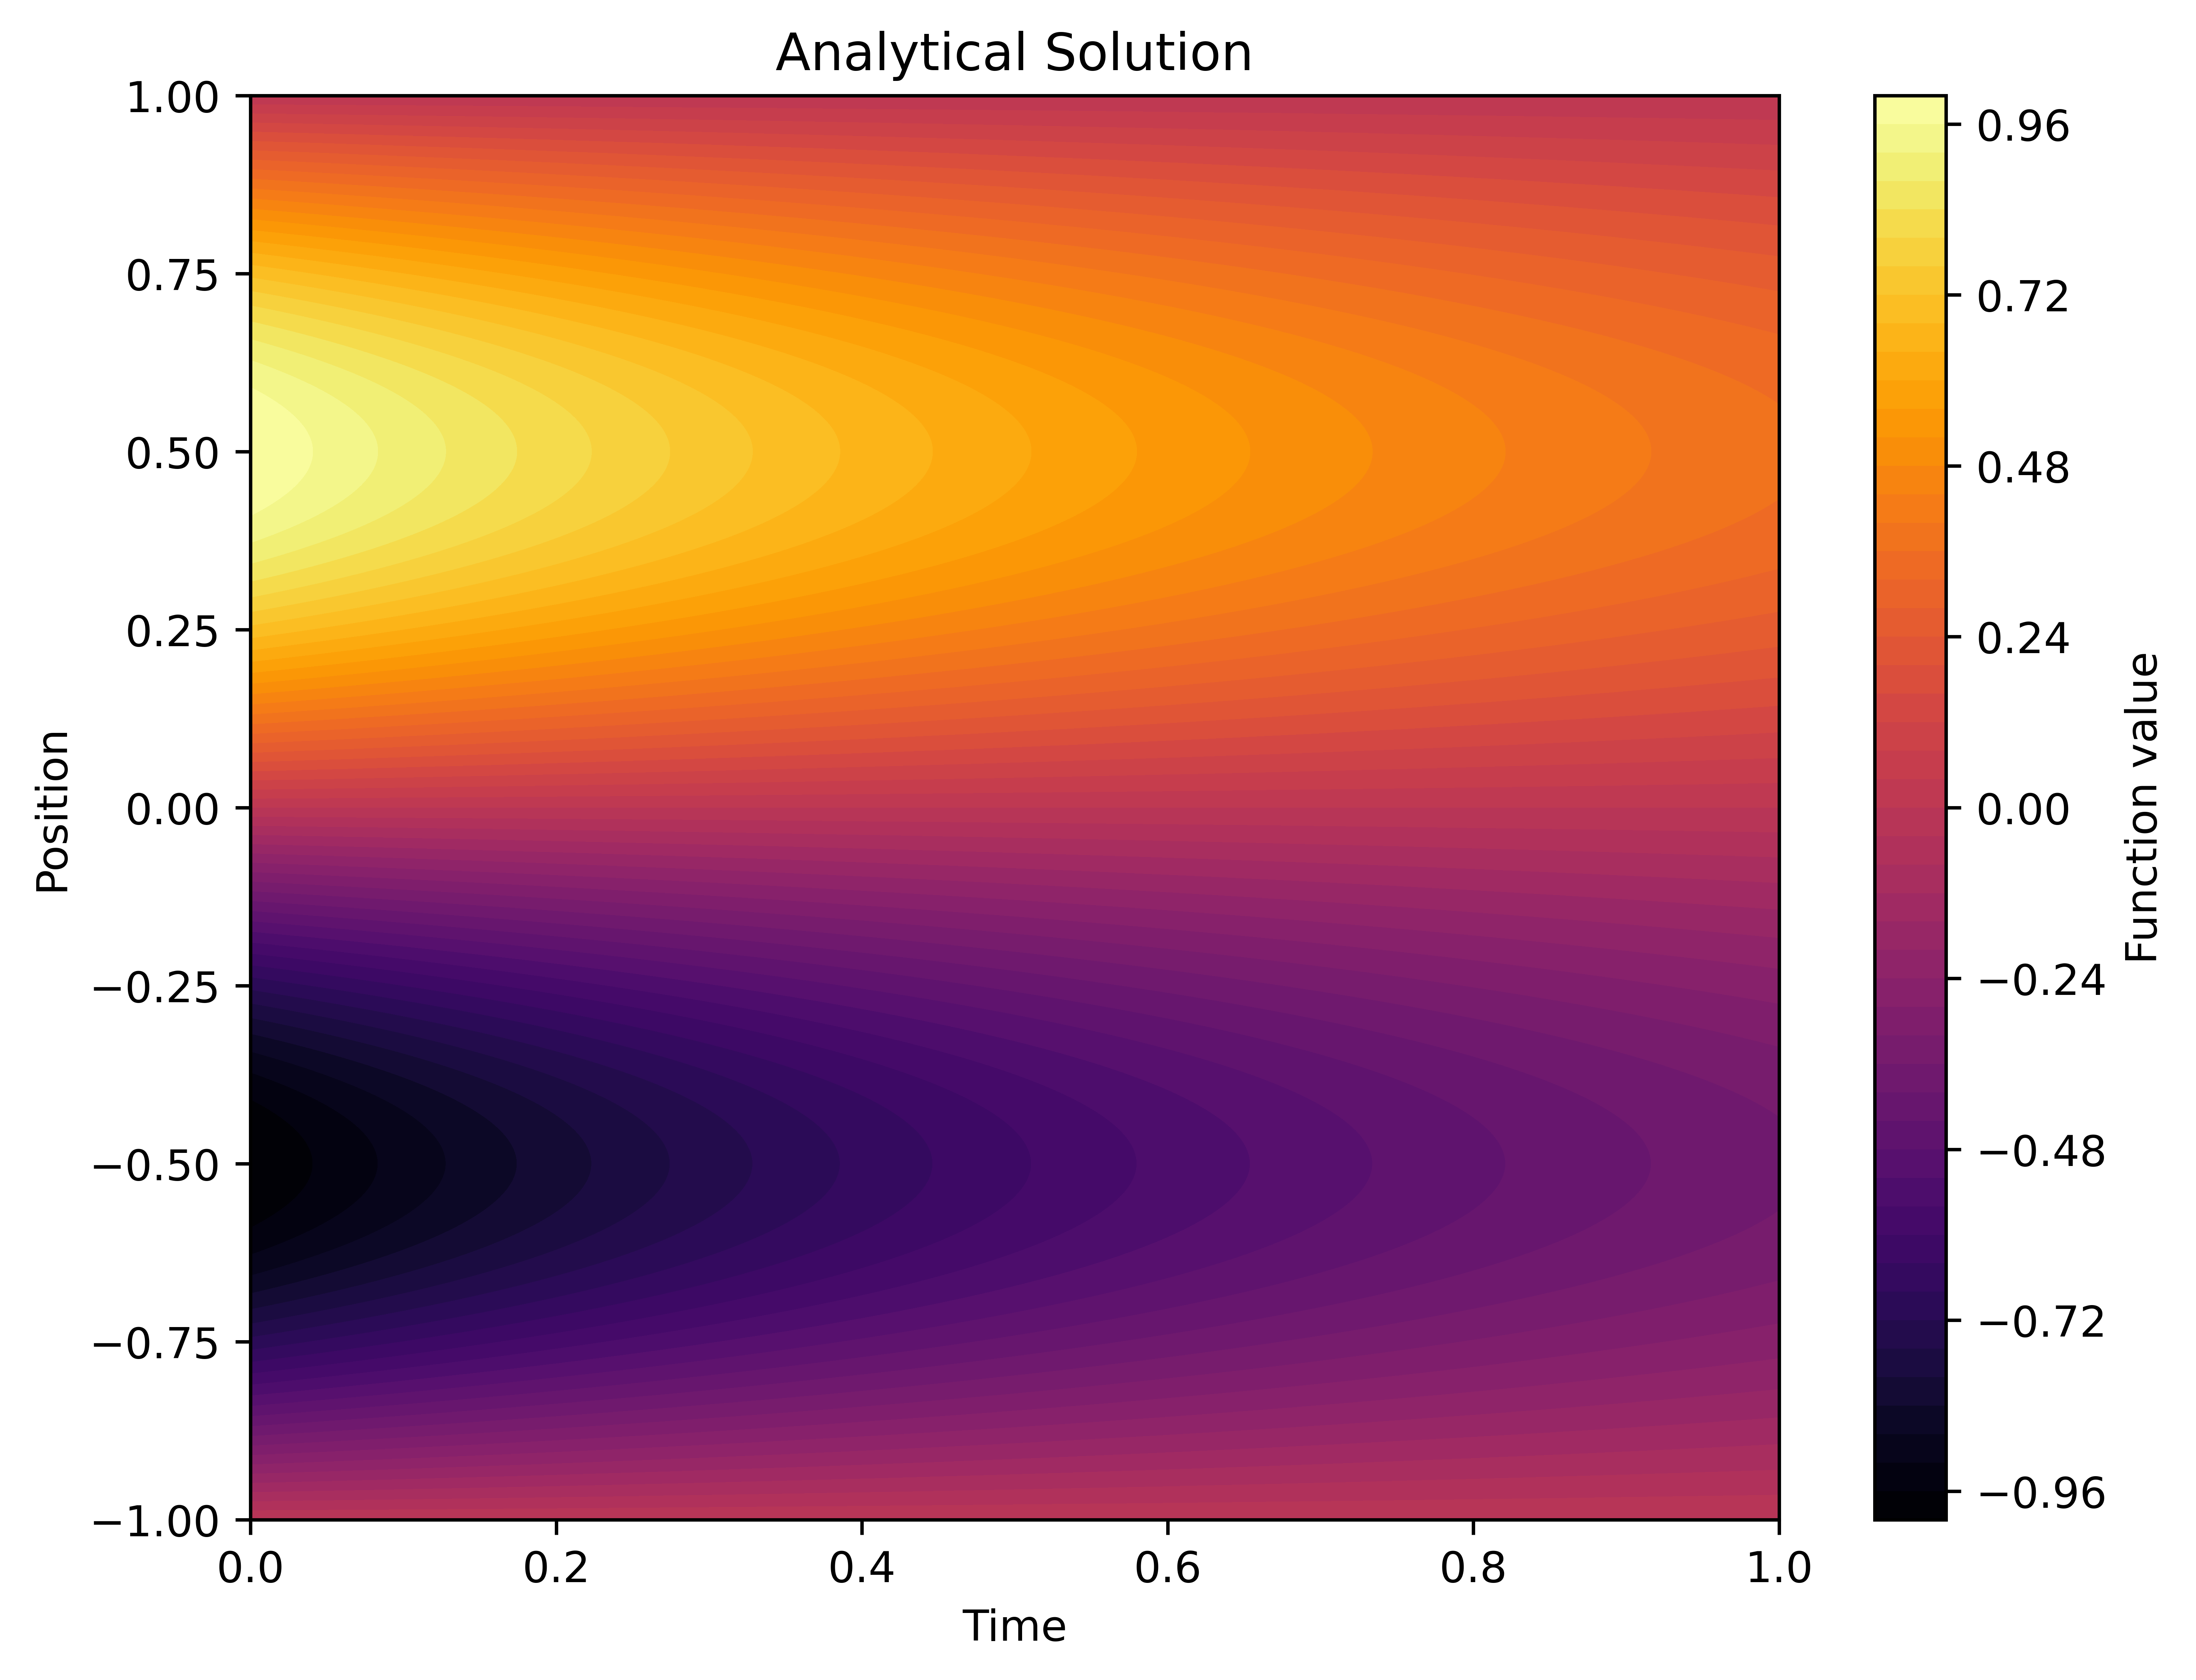

In [16]:
# Generate a grid of points
x = np.linspace(-1, 1, 1000)
t = np.linspace(0, 1, 1000)
X, T = np.meshgrid(x, t)

# Evaluate the function on the grid
points = np.vstack([X.ravel(), T.ravel()]).T
Z = func(points).reshape(X.shape)

# Create the plot
plt.figure(figsize=(8, 6), dpi=800)
plt.contourf(T, X, Z, levels=50, cmap='inferno')
plt.colorbar(label='Function value')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Analytical Solution')
plt.show()


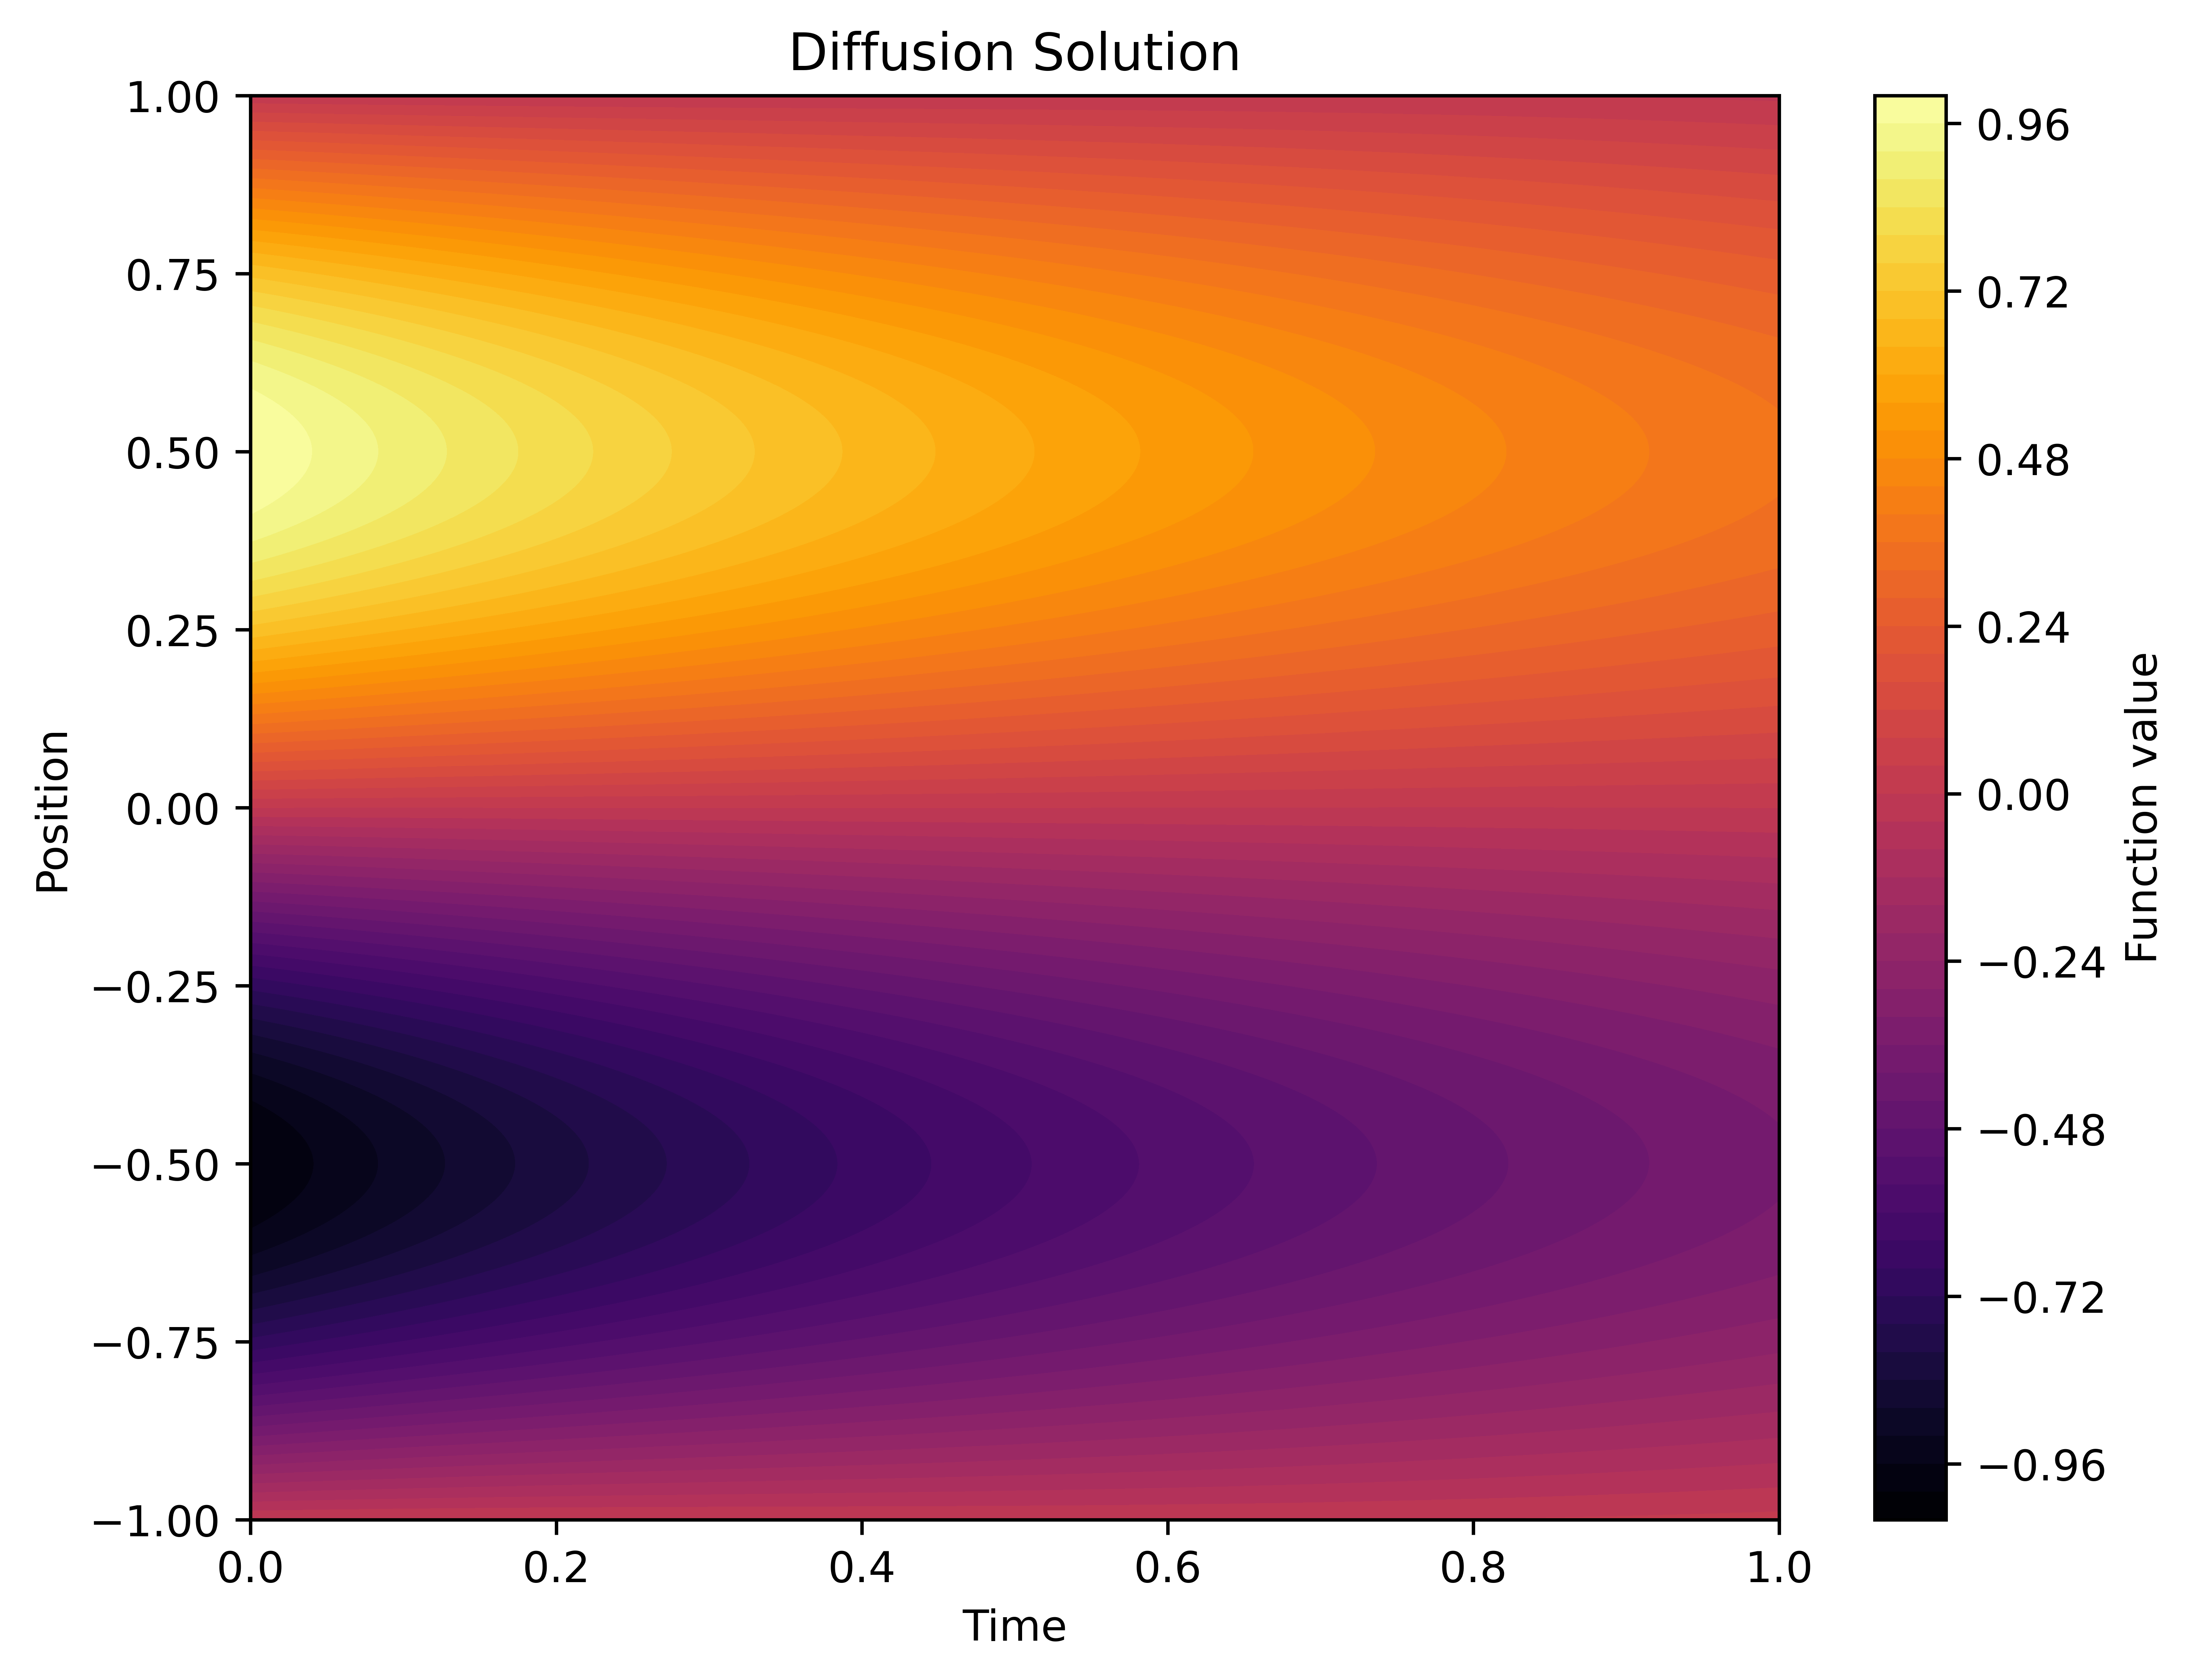

In [17]:
# Generate a grid of points
x = np.linspace(-1, 1, 1000)
t = np.linspace(0, 1, 1000)
X, T = np.meshgrid(x, t)

# Evaluate the function on the grid
points = np.vstack([X.ravel(), T.ravel()]).T
Z = model.predict(points).reshape(X.shape)

# Create the plot
plt.figure(figsize=(8, 6), dpi = 800)
plt.contourf(T, X, Z, levels=50, cmap='inferno')
plt.colorbar(label='Function value')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Diffusion Solution')
plt.show()
